# Multipitch tracking using Echo State Networks

## Introduction

In this notebook, we demonstrate how the ESN can deal with multipitch tracking, a challenging multilabel classification problem in music analysis.

As this is a computationally expensive task, we have pre-trained models to serve as an entry point.

At first, we import all packages required for this task. You can find the import statements below.

In [1]:
import numpy as np
import os
import csv
from sklearn.base import clone
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
from joblib import dump, load

import librosa
from madmom.processors import SequentialProcessor, ParallelProcessor
from madmom.audio import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.filters import LogarithmicFilterbank
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor, SpectrogramDifferenceProcessor

from pyrcn.util import FeatureExtractor
from pyrcn.echo_state_network import SeqToSeqESNClassifier
from pyrcn.datasets import fetch_maps_piano_dataset
from pyrcn.metrics import mean_squared_error
from pyrcn.model_selection import SequentialSearchCV

from matplotlib import pyplot as plt
from matplotlib import ticker
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10
%matplotlib inline

import pandas as pd
import seaborn as sns
from mir_eval import multipitch

## Feature extraction

The acoustic features extracted from the input signal are obtained by filtering short-term spectra (window length 4096 samples and hop size 10 ms) with a bank of triangular filters in the frequency domain with log-spaced frequencies. The frequency range was 30 Hz to 17 000 Hz and we used 12 filters per octave. We used logarithmic magnitudes and added 1 inside the logarithm to ensure a minimum value of 0 for a frame without energy. The first derivative between adjacent frames was added in order to enrich the features by temporal information. Binary labels indicating absent (value 0) or present (value 1) pitches for each frame are assigned to each frame. Note that this task is a multilabel classification. Each MIDI pitch is a separate class, and multiple or no classes can be active at a discrete frame index.

For a more detailed description, please have a look in our repository ([https://github.com/TUD-STKS/Automatic-Music-Transcription](https://github.com/TUD-STKS/Automatic-Music-Transcription)) with several detailed examples for music analysis tasks.

In [2]:
def create_feature_extraction_pipeline(sr=44100, frame_sizes=[1024, 2048, 4096], fps_hz=100.):
    audio_loading = Pipeline([("load_audio", FeatureExtractor(librosa.load, sr=sr, mono=True)),
                              ("normalize", FeatureExtractor(librosa.util.normalize, norm=np.inf))])

    sig = SignalProcessor(num_channels=1, sample_rate=sr)
    multi = ParallelProcessor([])
    for frame_size in frame_sizes:
        frames = FramedSignalProcessor(frame_size=frame_size, fps=fps_hz)
        stft = ShortTimeFourierTransformProcessor()  # caching FFT window
        filt = FilteredSpectrogramProcessor(filterbank=LogarithmicFilterbank, num_bands=12, fmin=30, fmax=17000,
                                            norm_filters=True, unique_filters=True)
        spec = LogarithmicSpectrogramProcessor(log=np.log10, mul=5, add=1)
        diff = SpectrogramDifferenceProcessor(diff_ratio=0.5, positive_diffs=True, stack_diffs=np.hstack)
        # process each frame size with spec and diff sequentially
        multi.append(SequentialProcessor([frames, stft, filt, spec, diff]))
    feature_extractor = FeatureExtractor(SequentialProcessor([sig, multi, np.hstack]))

    feature_extraction_pipeline = Pipeline([("audio_loading", audio_loading),
                                            ("feature_extractor", feature_extractor)])
    return feature_extraction_pipeline

## Load and preprocess the dataset

This might require a large amount of and memory. 

In [3]:
# Load and preprocess the dataset
feature_extraction_pipeline = create_feature_extraction_pipeline(sr=44100, frame_sizes=[2048], fps_hz=100)
# New object -> PyTorch dataloader / Matlab datastore
X_train, X_test, y_train, y_test = fetch_maps_piano_dataset(data_origin="/projects/p_transcriber/MAPS", 
                                                            data_home=None, preprocessor=feature_extraction_pipeline,
                                                            force_preprocessing=False, label_type="pitch")

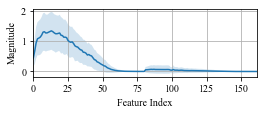

In [4]:
def tsplot(ax, data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

fig, ax = plt.subplots()
fig.set_size_inches(4, 1.25)
tsplot(ax, np.concatenate(np.hstack((X_train, X_test))))
ax.set_xlabel('Feature Index')
ax.set_ylabel('Magnitude')
plt.grid()
plt.savefig('features_statistics.pdf', bbox_inches='tight', pad_inches=0)

## Set up a ESN

To develop an ESN model for multipitch tracking, we need to tune several hyper-parameters, e.g., input_scaling, spectral_radius, bias_scaling and leaky integration.

We follow the way proposed in the paper for multipitch tracking and for acoustic modeling of piano music to optimize hyper-parameters sequentially.

We define the search spaces for each step together with the type of search (a grid search in this context).

At last, we initialize a SeqToSeqESNClassifier with the desired output strategy and with the initially fixed parameters.


In [5]:
initially_fixed_params = {'hidden_layer_size': 500,
                          'input_activation': 'identity',
                          'k_in': 10,
                          'bias_scaling': 0.0,
                          'reservoir_activation': 'tanh',
                          'leakage': 1.0,
                          'bi_directional': False,
                          'k_rec': 10,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-5,
                          'random_state': 42}

step1_esn_params = {'leakage': np.linspace(0.1, 1.0, 10)}
step2_esn_params = {'input_scaling': np.linspace(0.1, 1.0, 10),
                    'spectral_radius': np.linspace(0.0, 1.5, 16)}

step3_esn_params = {'bias_scaling': np.linspace(0.0, 2.0, 21)}

kwargs = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(mean_squared_error, greater_is_better=False, needs_proba=True)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', GridSearchCV, step1_esn_params, kwargs),
            ('step2', GridSearchCV, step2_esn_params, kwargs),
            ('step3', GridSearchCV, step3_esn_params, kwargs)]

base_esn = SeqToSeqESNClassifier(**initially_fixed_params)

## Optimization

We provide a SequentialSearchCV that basically iterates through the list of searches that we have defined before. It can be combined with any model selection tool from scikit-learn.

In [6]:
try: 
    sequential_search = load("sequential_search.joblib")
except FileNotFoundError:
    print(FileNotFoundError)
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train, y_train)
    dump(sequential_search, "sequential_search.joblib")

## Visualize hyper-parameter optimization

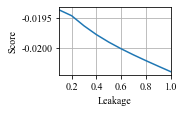

In [7]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
plt.xlabel("Leakage")
plt.ylabel("Score")
plt.xlim((0.1, 1))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.grid()
plt.savefig('optimize_leakage.pdf', bbox_inches='tight', pad_inches=0)

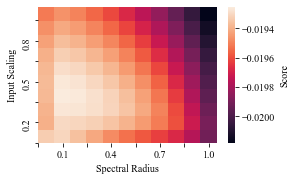

In [8]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
pvt = pd.pivot_table(df,
                     values='mean_test_score', index='param_input_scaling', columns='param_spectral_radius')

pvt.columns = pvt.columns.astype(float)
pvt2 =  pd.DataFrame(pvt.loc[pd.IndexSlice[0:1], pd.IndexSlice[0.0:1.0]])

fig = plt.figure()
ax = sns.heatmap(pvt2, xticklabels=pvt2.columns.values.round(2), yticklabels=pvt2.index.values.round(2), cbar_kws={'label': 'Score'})
ax.invert_yaxis()
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")
fig.set_size_inches(4, 2.5)
tick_locator = ticker.MaxNLocator(10)
ax.yaxis.set_major_locator(tick_locator)
ax.xaxis.set_major_locator(tick_locator)
plt.savefig('optimize_is_sr.pdf', bbox_inches='tight', pad_inches=0)

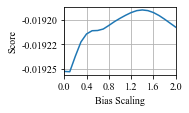

In [9]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("Score")
plt.xlim((0, 2))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.grid()
plt.savefig('optimize_bias_scaling.pdf', bbox_inches='tight', pad_inches=0)

## Test the ESN

Finally, we test the ESN on unseen data.

In [10]:
def _midi_to_frequency(p):
    return 440. * (2 ** ((p-69)/12))


def get_mir_eval_rows(y, fps=100.):
    time_t = np.arange(len(y)) / fps
    freq_hz = [_midi_to_frequency(np.asarray(np.nonzero(row))).ravel() for row in y]
    return time_t, freq_hz

In [11]:
esn = load("esn_500_False.joblib")
y_test_pred = esn.predict_proba(X=X_test)
scores = np.zeros(shape=(10, 14))
for k, thr in enumerate(np.linspace(0.1, 0.9, 9)):
    res = []
    for y_true, y_pred in zip(y_test, y_test_pred):
        times_res, freqs_hz_res = get_mir_eval_rows(y_pred[:, 1:]>thr, fps=100.)
        times_ref, freqs_hz_ref = get_mir_eval_rows(y_true[:, 1:]>thr, fps=100.)
        res.append(multipitch.metrics(ref_time=times_ref, ref_freqs=freqs_hz_ref, est_time=times_res, est_freqs=freqs_hz_res))
    scores[k, :] = np.mean(res, axis=0)

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


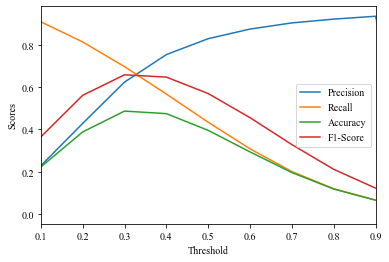

In [12]:
plt.plot(np.linspace(0.1, 1, 10), scores[:, :3])
plt.plot(np.linspace(0.1, 1, 10), 2*scores[:, 0]*scores[:, 1] / (scores[:, 0] + scores[:, 1]))
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.xlim((0.1, 0.9))
plt.legend(("Precision", "Recall", "Accuracy", "F1-Score"))